In [1]:
import pandas as pd
import pickle
import yfinance as yf
import numpy as np
from sklearn.linear_model import LogisticRegression

In [2]:
# tickers = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'SPG', 'AMT', 'PLD', 'EQR', 'PSA',
#        'WELL', 'NEE', 'DUK', 'D', 'SO', 'EXC', 'AEP']


tickers = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS']

# , 'SPG', 'AMT', 'PLD', 'EQR', 'PSA',
#        'WELL', 'NEE', 'DUK', 'D', 'SO', 'EXC', 'AEP']

start_date = "1970-01-01"
end_date = "2023-6-30"
data = {}

for ticker in tickers:
    data[ticker] = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
close_prices = pd.DataFrame({ticker: df['Close'] for ticker, df in data.items()})

# Print first few rows of the close prices dataframe
close_prices.head()

,JPM,BAC,WFC,C,GS,MS
Date,,,,,,
1972-06-01,NaN,NaN,0.880208,NaN,NaN,NaN
1972-06-02,NaN,NaN,0.882813,NaN,NaN,NaN
1972-06-05,NaN,NaN,0.895833,NaN,NaN,NaN
1972-06-06,NaN,NaN,0.895833,NaN,NaN,NaN
1972-06-07,NaN,NaN,0.888021,NaN,NaN,NaN


In [4]:
fed_data = pd.read_csv('../raw/FEDFUNDS_2_txt/FEDFUNDS_2_Vintages_Starting_1996_12_03.txt', sep = '\t')[['observation_date','FEDFUNDS_20230703']]

In [5]:
fed_data.rename(columns={'observation_date': 'Date'}, inplace=True)
fed_data.Date = pd.to_datetime(fed_data.Date)
fed_data.set_index('Date', inplace=True)
fed_data['fed_hike'] = (fed_data['FEDFUNDS_20230703'].diff() > 0).astype(int)

In [6]:
fed_data

,FEDFUNDS_20230703,fed_hike
Date,,
1954-07-01,0.80,0
1954-08-01,1.22,1
1954-09-01,1.07,0
1954-10-01,0.85,0
1954-11-01,0.83,0
...,...,...
2023-02-01,4.57,1
2023-03-01,4.65,1
2023-04-01,4.83,1


In [7]:
ff_data = pd.read_csv('../raw/FEDFUNDS_2_txt/F-F_Research_Data_5_Factors_2x3_daily.CSV', sep = ',', header=1)

In [8]:
ff_data.Date = pd.to_datetime(ff_data.Date, format='%Y%m%d')
ff_data.set_index('Date', inplace=True)

In [9]:
ff_data

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07-01,-0.67,0.02,-0.35,0.03,0.13,0.012
1963-07-02,0.79,-0.28,0.28,-0.08,-0.21,0.012
1963-07-03,0.63,-0.18,-0.10,0.13,-0.25,0.012
1963-07-05,0.40,0.09,-0.28,0.07,-0.30,0.012
1963-07-08,-0.63,0.07,-0.20,-0.27,0.06,0.012
...,...,...,...,...,...,...
2023-06-26,-0.48,0.00,1.30,0.62,0.67,0.019
2023-06-27,1.21,0.33,-0.51,0.23,-0.74,0.019
2023-06-28,0.04,0.48,-0.40,-0.63,-0.42,0.019


# Joining data and preprocessing

In [10]:
df = fed_data.join(ff_data)

In [11]:
df = df.join(close_prices)

In [12]:
# df.replace(0.0, np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

In [13]:
df

,FEDFUNDS_20230703,fed_hike,Mkt-RF,SMB,HML,RMW,CMA,RF,JPM,BAC,WFC,C,GS,MS
Date,,,,,,,,,,,,,,
1954-07-01,0.80,0,-0.67,0.02,-0.35,0.03,0.13,0.012,5.111111,4.656250,0.880208,16.133125,64.187500,8.000000
1954-08-01,1.22,1,-0.67,0.02,-0.35,0.03,0.13,0.012,5.111111,4.656250,0.880208,16.133125,64.187500,8.000000
1954-09-01,1.07,0,-0.67,0.02,-0.35,0.03,0.13,0.012,5.111111,4.656250,0.880208,16.133125,64.187500,8.000000
1954-10-01,0.85,0,-0.67,0.02,-0.35,0.03,0.13,0.012,5.111111,4.656250,0.880208,16.133125,64.187500,8.000000
1954-11-01,0.83,0,-0.67,0.02,-0.35,0.03,0.13,0.012,5.111111,4.656250,0.880208,16.133125,64.187500,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,4.57,1,1.19,0.63,-1.67,-0.19,-1.09,0.018,139.589996,35.919998,47.330002,52.150002,365.709991,98.190002
2023-03-01,4.65,1,-0.42,0.40,0.62,0.19,0.59,0.016,142.550003,34.139999,46.680000,51.500000,346.230011,96.190002
2023-04-01,4.83,1,-0.42,0.40,0.62,0.19,0.59,0.016,142.550003,34.139999,46.680000,51.500000,346.230011,96.190002


# Inverse Probability Weight

In [14]:
df = df[df.index >= '1990-01-01']

stock_suspect = tickers[0]
print(stock_suspect)

economic_indicators = ff_data.columns.values
print(economic_indicators)

fed_hike_column = 'fed_hike'

JPM
['Mkt-RF' 'SMB' 'HML' 'RMW' 'CMA' 'RF']


In [15]:
X = df[economic_indicators]  # you can add more covariates as required
y = df[fed_hike_column]

In [16]:
model = LogisticRegression(solver='lbfgs').fit(X, y)
df['propensity_score'] = model.predict_proba(X)[:, 1]

/var/folders/v5/7bgr9j_j4csbfbrzllf2d13r0000gn/T/ipykernel_11511/2094832471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['propensity_score'] = model.predict_proba(X)[:, 1]


In [17]:
# Step 2: Compute Inverse Probability Weights
df['weight'] = np.where(df[fed_hike_column] == 1, 
                        1 / df['propensity_score'],
                        1 / (1 - df['propensity_score']))

/var/folders/v5/7bgr9j_j4csbfbrzllf2d13r0000gn/T/ipykernel_11511/2082682706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'] = np.where(df[fed_hike_column] == 1,


In [18]:
# Step 3: Compute counterfactual means
counterfactual_mean_treated = np.average(df[df[fed_hike_column] == 0][stock_suspect], weights=df[df[fed_hike_column] == 0]['weight'])
counterfactual_mean_untreated = np.average(df[df[fed_hike_column] == 1][stock_suspect], weights=df[df[fed_hike_column] == 1]['weight'])


In [19]:
print(f"Counterfactual mean return for days with rate hike (had there been no hike): {counterfactual_mean_treated}")
print(f"Counterfactual mean return for days without rate hike (had there been a hike): {counterfactual_mean_untreated}")


Counterfactual mean return for days with rate hike (had there been no hike): 50.307593697360424
Counterfactual mean return for days without rate hike (had there been a hike): 55.337232246549306


In [20]:
cov_matrix_treated = np.cov(df[df[fed_hike_column] == 0][[fed_hike_column, stock_suspect]], rowvar=False, aweights=df[df[fed_hike_column] == 0]['weight'])
cov_matrix_untreated = np.cov(df[df[fed_hike_column] == 1][[fed_hike_column, stock_suspect]], rowvar=False, aweights=df[df[fed_hike_column] == 1]['weight'])

In [21]:
print("Covariance matrix for days with rate hike:")
print(cov_matrix_treated)
print("\nCovariance matrix for days without rate hike:")
print(cov_matrix_untreated)

Covariance matrix for days with rate hike:
[[   0.            0.        ]
 [   0.         1457.03991764]]

Covariance matrix for days without rate hike:
[[   0.            0.        ]
 [   0.         1441.25856759]]


In [22]:
tickers

['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS']

In [23]:
# Step 3: Compute a single counterfactual covariance matrix for all stocks with relation to fed hike
columns_of_interest = [fed_hike_column] + tickers
cov_matrix_treated = np.cov(df[df[fed_hike_column] == 0][columns_of_interest], rowvar=False, aweights=df[df[fed_hike_column] == 0]['weight'])
cov_matrix_untreated = np.cov(df[df[fed_hike_column] == 1][columns_of_interest], rowvar=False, aweights=df[df[fed_hike_column] == 1]['weight'])

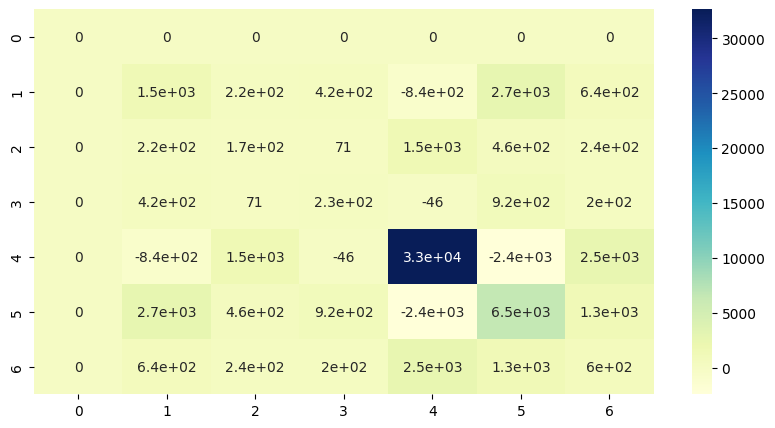

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.heatmap(cov_matrix_treated, cmap="YlGnBu", annot=True)
plt.show()

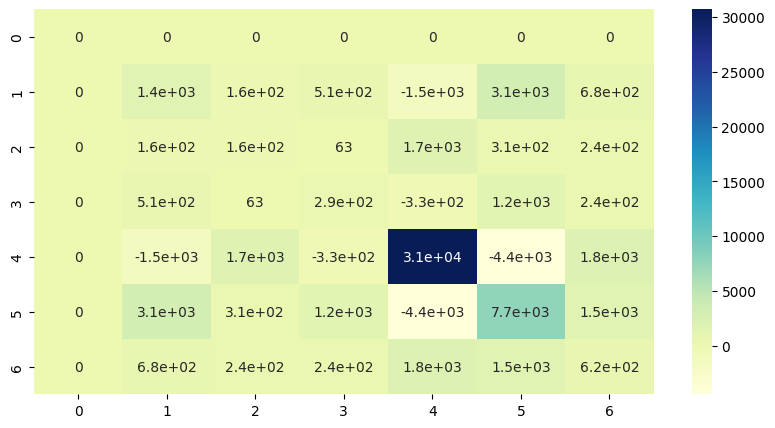

In [25]:
plt.figure(figsize=(10, 5))
sns.heatmap(cov_matrix_untreated, cmap="YlGnBu", annot=True)
plt.show()

In [26]:
cov_matrix_ordinary = np.cov(df[tickers], rowvar=False)

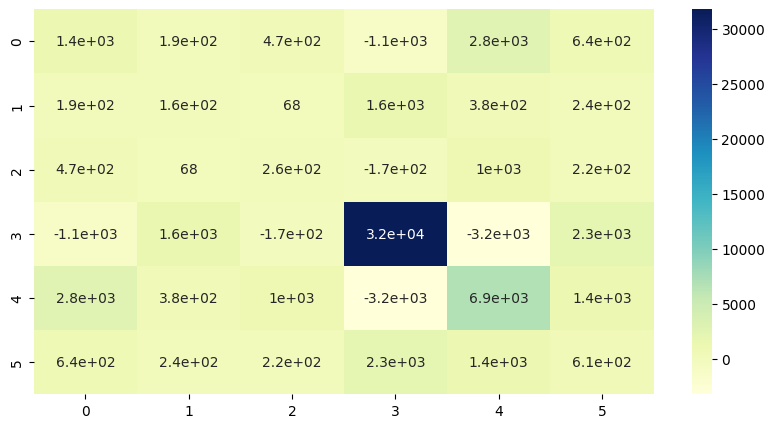

In [27]:
plt.figure(figsize=(10, 5))
sns.heatmap(cov_matrix_ordinary, cmap="YlGnBu", annot=True)
plt.show()